In [106]:
!pip install pywavelets

### Import Required Libraries:

In [107]:
import pandas as pd
import numpy as np
from array import *
from scipy.signal import butter, filtfilt , find_peaks  , ellip
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pywt


### Load the data

In [144]:
# Load the data from CSV file
data = pd.read_csv('filtered_output.csv')

### Process the Data

In [145]:
data.head()
# Calculate time range
if len(data) > 1:
    first_relative_time = data.loc[0, "relative_time_seconds"]
    last_relative_time = data.loc[len(data) - 1, "relative_time_seconds"]
    time_range = last_relative_time - first_relative_time
    print(f"Time range of filtered data: {time_range} seconds")
data.loc[:,"CSI_DATA"]
index = list(range(0,len(data)-1))

AmpCSI=np.zeros((len(data),64))
PhaseCSI=np.zeros((len(data),64))


for i in index:
  parts = data.loc[:,"CSI_DATA"][i].split(' ')
  # rawCSI=[s.strip('[') for s in parts]
  rawCSI=[s.strip('[') for s in parts]
  rawCSI=[s.strip(']') for s in rawCSI]
  #rawCSI.pop()

  ImCSI=np.array(rawCSI[::2],dtype=np.int64)
  ReCSI=np.array(rawCSI[1::2],dtype=np.int64)
  AmpCSI[i][:]=np.sqrt(np.power(ImCSI[:],2) + np.power(ReCSI[:],2))

  PhaseCSI[i][:]= np.arctan2(ImCSI[:], ReCSI[:])

Amp=np.concatenate((AmpCSI[:,6:32], AmpCSI[:,33:59]), axis=1)
Pha=np.concatenate((PhaseCSI[:,6:32], PhaseCSI[:,33:59]), axis=1)
csi_data = Amp

Time range of filtered data: 115.96807799999999 seconds


### Remove DC Offset

In [146]:
# Remove the DC offset by subtracting the mean
signal_dc_removed = csi_data - np.mean(csi_data , axis=0)
print(signal_dc_removed.shape)

(10720, 52)


### Smoothing (Moving Average Filter):

In [147]:
def smooth(a,WSZ):
    # a: NumPy 1-D array containing the data to be smoothed
    # WSZ: smoothing window size needs, which must be odd number,
    # as in the original MATLAB implementation
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))
def movingAverage(signal, window):
    """
    Apply a moving average filter to each column of a 2D signal array.

    Parameters:
    - signal: 2D numpy array where each column represents a separate signal to smooth.
    - window: Size of the moving average window.

    Returns:
    - smoothed_signal: 2D numpy array of the same shape as the input signal.
    """
    # Initialize a 12006 x 52 array filled with zeros
    C2 = np.zeros((signal.shape[0],signal.shape[1] ))
    # Apply moving average to each column
    for i in range(signal.shape[1]):
      C2[:, i] = smooth(signal[:, i], window)

    # Optionally replace NaNs introduced by centering with 0 or other method
    # smoothed_signal = np.nan_to_num(smoothed_signal)

    return C2

# Apply moving average to each column
# smoothed_signal = movingAverage(signal_dc_removed, window=5)  # digital twin
smoothed_signal = movingAverage(signal_dc_removed, window=11) # for our data set
print(smoothed_signal)

[[  0.2792716    0.14656979   0.94091821 ...  -0.42649766  -0.20405938
   -0.02410125]
 [  0.74546997   0.61276816   1.06165406 ...  -0.11020376   0.05715047
   -0.09203186]
 [  0.89590962   0.76320781   1.12646426 ...  -0.20459187   0.14244287
   -0.04145311]
 ...
 [ -4.32402319  -4.25860294  -4.10506241 ...  -2.39085317  -2.56735822
   -2.36040432]
 [ -5.67629005  -5.80899186  -5.6989609  ...  -3.20485114  -3.5923314
   -3.41237327]
 [-17.96901599 -18.1017178  -18.29446585 ... -12.79581453 -12.57337626
  -12.39341813]]


### Bandpass Filtering (Wavelet):

#### Heart Rate

In [112]:
def wavelet_bandpass_filter(data, sampling_rate, lowcut, highcut, wavelet='sym5'):
    """
    Applies a wavelet-based bandpass filter to keep only the coefficients within the specified frequency range.

    Parameters:
        data (array-like): Input signal (e.g., CSI amplitude or phase data).
        sampling_rate (float): Sampling frequency of the input signal (Hz).
        lowcut (float): Lower bound of the desired frequency range (Hz).
        highcut (float): Upper bound of the desired frequency range (Hz).
        wavelet (str): Type of wavelet to use (default is 'db4').

    Returns:
        np.ndarray: Filtered signal with coefficients within the specified frequency range.
    """
    # Compute the maximum decomposition level
    max_level = pywt.dwt_max_level(len(data), pywt.Wavelet(wavelet))

    # Calculate frequency ranges for each level
    nyquist = 0.5 * sampling_rate
    level_frequencies = [(nyquist / (2 ** (i + 1)), nyquist / (2 ** i)) for i in range(max_level)]

    # print("Decomposition Levels and Frequency Ranges:")
    # for i, (low, high) in enumerate(level_frequencies):
    #     print(f"Level {i + 1}: {low:.2f} Hz - {high:.2f} Hz")

    # Determine the suitable levels
    target_levels = [
        i + 1 for i, (low, high) in enumerate(level_frequencies)
        if high >= lowcut and low <= highcut
    ]
    target_levels=[ 2, 3 , 4 , 5]
    if not target_levels:
        raise ValueError(f"No suitable levels found for lowcut: {lowcut}, highcut: {highcut}")

    # Decompose the signal
    coeffs = pywt.wavedec(data, wavelet, level=max_level)

    # Zero out coefficients outside the desired frequency range
    filtered_coeffs = []
    for i, coeff in enumerate(coeffs):
        if i in target_levels:
            filtered_coeffs.append(coeff)
        else:
            filtered_coeffs.append(np.zeros_like(coeff))

    # Reconstruct the signal
    filtered_signal = pywt.waverec(filtered_coeffs, wavelet)

    # Ensure the reconstructed signal matches the original signal length
    return filtered_signal[:len(data)]
# Example parameters for the wavelet filter
fs = signal_dc_removed.shape[0] / time_range  # Sampling frequency
lowcut = 0.1  # Lower cutoff frequency in Hz
highcut = 0.5  # Upper cutoff frequency in Hz

# Apply the filter along the specified axis to get the filtered signal
filtered_signal_wavelet = np.apply_along_axis(wavelet_bandpass_filter, 0, smoothed_signal, fs, lowcut, highcut)

print("Filtered signal shape:", filtered_signal_wavelet.shape)
# High-pass filter for baseline correction
def highpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

b,a  = highpass_filter(data, cutoff=1, fs=fs)
# Apply the filter to each channel in the signal
for i in range(filtered_signal_wavelet.shape[1]):
    # Use filtfilt to apply zero-phase filtering to avoid phase distortion
    filtered_signal_wavelet[:, i] = filtfilt(b, a, filtered_signal_wavelet[:, i])

Filtered signal shape: (11027, 52)


#### Respiration Rate

In [113]:
def wavelet_bandpass_filter(data, sampling_rate, lowcut, highcut, wavelet='sym5'):
    """
    Applies a wavelet-based bandpass filter to keep only the coefficients within the specified frequency range.

    Parameters:
        data (array-like): Input signal (e.g., CSI amplitude or phase data).
        sampling_rate (float): Sampling frequency of the input signal (Hz).
        lowcut (float): Lower bound of the desired frequency range (Hz).
        highcut (float): Upper bound of the desired frequency range (Hz).
        wavelet (str): Type of wavelet to use (default is 'db4').

    Returns:
        np.ndarray: Filtered signal with coefficients within the specified frequency range.
    """
    # Compute the maximum decomposition level
    max_level = pywt.dwt_max_level(len(data), pywt.Wavelet(wavelet))

    # Calculate frequency ranges for each level
    nyquist = 0.5 * sampling_rate
    level_frequencies = [(nyquist / (2 ** (i + 1)), nyquist / (2 ** i)) for i in range(max_level)]

    # print("Decomposition Levels and Frequency Ranges:")
    # for i, (low, high) in enumerate(level_frequencies):
    #     print(f"Level {i + 1}: {low:.2f} Hz - {high:.2f} Hz")

    # Determine the suitable levels
    target_levels = [
        i + 1 for i, (low, high) in enumerate(level_frequencies)
        if high >= lowcut and low <= highcut
    ]
    target_levels=[  2, 3]
    if not target_levels:
        raise ValueError(f"No suitable levels found for lowcut: {lowcut}, highcut: {highcut}")

    # Decompose the signal
    coeffs = pywt.wavedec(data, wavelet, level=max_level)

    # Zero out coefficients outside the desired frequency range
    filtered_coeffs = []
    for i, coeff in enumerate(coeffs):
        if i in target_levels:
            filtered_coeffs.append(coeff)
        else:
            filtered_coeffs.append(np.zeros_like(coeff))

    # Reconstruct the signal
    filtered_signal = pywt.waverec(filtered_coeffs, wavelet)

    # Ensure the reconstructed signal matches the original signal length
    return filtered_signal[:len(data)]
# Example parameters for the wavelet filter
fs = signal_dc_removed.shape[0] / time_range  # Sampling frequency
lowcut = 0.1  # Lower cutoff frequency in Hz
highcut = 0.5  # Upper cutoff frequency in Hz

# Apply the filter along the specified axis to get the filtered signal
filtered_signal_wavelet_pre = np.apply_along_axis(wavelet_bandpass_filter, 0, smoothed_signal, fs, lowcut, highcut)

print("Filtered signal shape:", filtered_signal_wavelet.shape)
# High-pass filter for baseline correction
def highpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

b,a  = highpass_filter(data, cutoff=0.17, fs=fs)
filtered_signal_wavelet = np.zeros_like(filtered_signal_wavelet_pre)
# Apply the filter to each channel in the signal
for i in range(filtered_signal_wavelet_pre.shape[1]):
    # Use filtfilt to apply zero-phase filtering to avoid phase distortion
    filtered_signal_wavelet[:, i] = filtfilt(b, a, filtered_signal_wavelet_pre[:, i])

Filtered signal shape: (11027, 52)


### Bandpass Filtering (Butterwoth):

In [159]:
def bandpass_filter(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order,[low, high], btype='band')
    return b,a

#### Heart rate

In [150]:
# Parameters for the bandpass filter
fs = smoothed_signal.shape[0]/time_range
lowcut=1.5
highcut = 2.1
# Design the filter
b, a = bandpass_filter( lowcut, highcut, fs, order=4)

# Apply the filter to each channel in the signal
filtered_signal_butterworth = np.zeros_like(smoothed_signal)
for i in range(smoothed_signal.shape[1]):
    # Use filtfilt to apply zero-phase filtering to avoid phase distortion
    filtered_signal_butterworth[:, i] = filtfilt(b, a, smoothed_signal[:, i])


#### Respiration Rate

In [160]:
# Parameters for the bandpass filter
fs = smoothed_signal.shape[0]/time_range
# lowcut = 0.1
lowcut=0.17
highcut = 0.6
highcut = 0.62

# Design the filter
b, a = bandpass_filter( lowcut, highcut, fs, order=4)

# Apply the filter to each channel in the signal
filtered_signal_butterworth = np.zeros_like(smoothed_signal)
for i in range(smoothed_signal.shape[1]):
    # Use filtfilt to apply zero-phase filtering to avoid phase distortion
    filtered_signal_butterworth[:, i] = filtfilt(b, a, smoothed_signal[:, i])
print(filtered_signal_butterworth)

[[-0.58893982 -0.65051663 -0.6408311  ... -0.7009423  -0.65448651
  -0.57227538]
 [-0.59903909 -0.65940995 -0.66546192 ... -0.71358403 -0.66979322
  -0.58802254]
 [-0.60918764 -0.6683256  -0.69011661 ... -0.72609408 -0.68500794
  -0.60369274]
 ...
 [ 0.00189464  0.00171096  0.00172112 ...  0.00207908  0.00190177
   0.00179976]
 [ 0.00167176  0.00151577  0.00152613 ...  0.00181179  0.00166129
   0.00157238]
 [ 0.00146451  0.00133289  0.00134312 ...  0.0015684   0.00144148
   0.00136452]]


### Bandpass Filtering(Elliptic)


In [117]:
# Design the bandpass filter using an elliptic filter
def ellip_bandpass(lowcut, highcut, fs, order=4, rp=1, rs=40):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # Elliptic filter design
    b, a = ellip(order, rp, rs, [low, high], btype='band')
    return b, a

#### Heart rate

In [118]:
# Parameters for the bandpass filter
fs = 100        # Sampling frequency
fs = signal_dc_removed.shape[0]/time_range
# print(fs)
lowcut = 1.5
highcut = 2.1
order = 4       # Filter order

# Design the filter
b, a = ellip_bandpass(lowcut, highcut, fs, order)

# Apply the filter to each channel in the signal
filtered_signal_ellip = np.zeros_like(smoothed_signal)
for i in range(smoothed_signal.shape[1]):
    # Use filtfilt to apply zero-phase filtering to avoid phase distortion
    filtered_signal_ellip[:, i] = filtfilt(b, a, smoothed_signal[:, i])

#### Respiration Rate

In [119]:
# Parameters for the bandpass filter
fs = signal_dc_removed.shape[0]/time_range
# print(fs)
lowcut = 0.211111    # Lower cutoff frequency for digital twin
# lowcut = 0.2   #0.2 for out data
highcut = 0.705556   # Upper cutoff frequency for digital twin
# highcut = 0.75    #0.75 for out data
order = 4       # Filter order

# Design the filter
b, a = ellip_bandpass(lowcut, highcut, fs, order)

# Apply the filter to each channel in the signal
filtered_signal_ellip = np.zeros_like(smoothed_signal)
for i in range(smoothed_signal.shape[1]):
    # Use filtfilt to apply zero-phase filtering to avoid phase distortion
    filtered_signal_ellip[:, i] = filtfilt(b, a, smoothed_signal[:, i])

# PCA

In [182]:
# Apply PCA to the filtered signal
pca = PCA()
pca.fit(filtered_signal_butterworth)
pca_components = pca.transform(filtered_signal_butterworth)

# Variance explained by each principal component
explained_variance = pca.explained_variance_

# Extract the first principal component
first_pc = pca_components[:, 0]
print(first_pc)



[-4.52415863 -4.61625961 -4.70814101 ...  0.021411    0.01984775
  0.01840036]


### Power Spectral Density (PSD) Calculation:

In [183]:
from scipy.signal import welch

def estimate_rr(data, fs):
    freqs, psd = welch(data, fs=fs, nperseg=len(data))

    freqs_symmetric = np.concatenate((-freqs[::-1], freqs))
    psd_symmetric = np.concatenate((psd[::-1], psd))

    # Identify the frequency with the highest PSD within the range
    peak_freq = freqs[np.argmax(psd)]
    # Convert peak frequency to breaths per minute
    rr_bpm = peak_freq * 60
    print(rr_bpm)
    return rr_bpm, psd_symmetric, freqs_symmetric

# Example usage:
bpm, psd_in_range, freqs_in_range = estimate_rr(first_pc, fs)
print("respiration rate: ", bpm)
# csi_data_28_2mins_with_movements_correct_timing

16.038896497017053
respiration rate:  16.038896497017053


### Visualisation

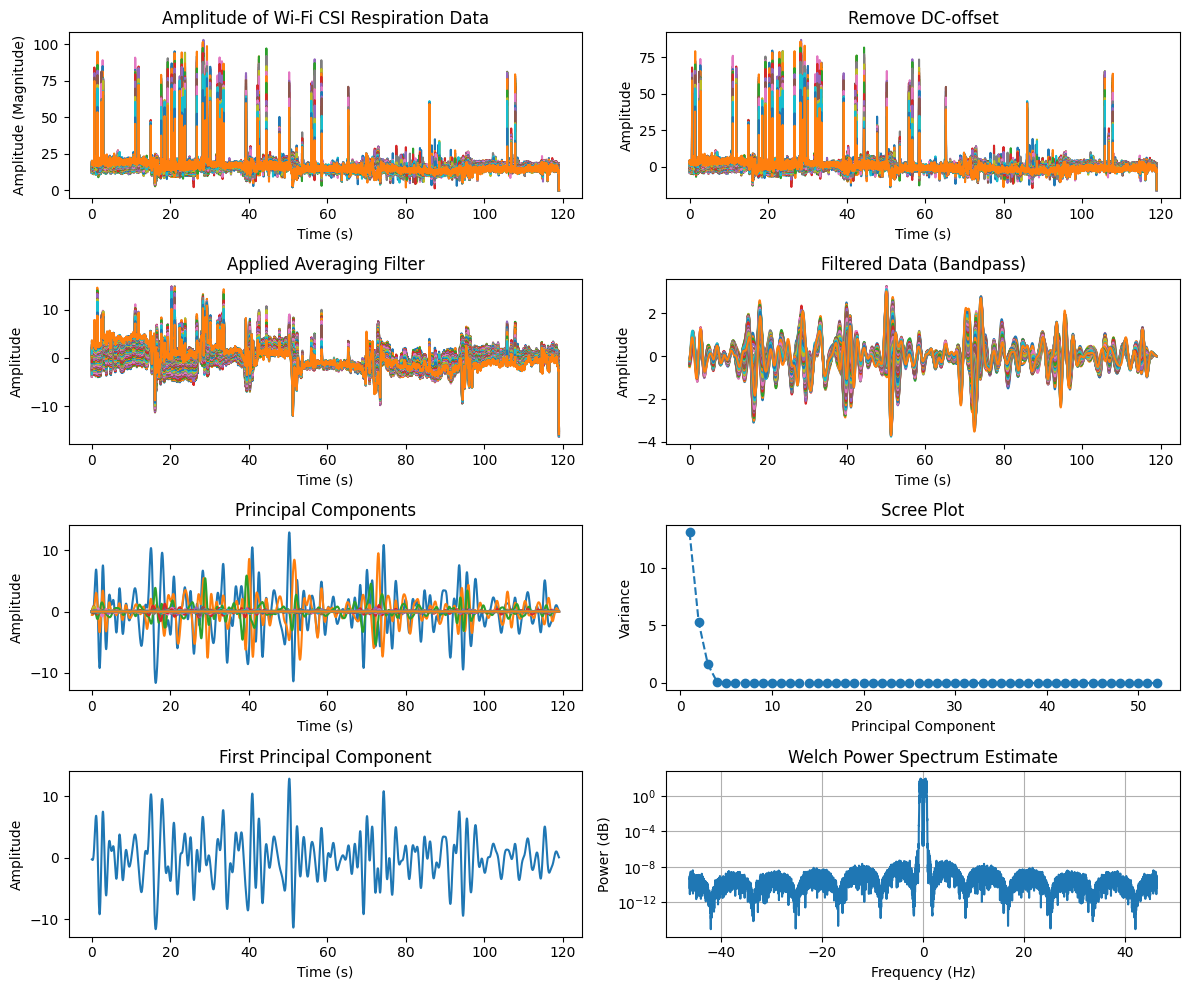

In [122]:
# Create a time array for x-axis in seconds
time = np.arange(csi_data.shape[0]) / fs

# Plotting
plt.figure(figsize=(12, 10))


# Plot the amplitude over time
plt.subplot(4, 2, 1)
plt.plot(time, csi_data)
plt.title('Amplitude of Wi-Fi CSI Respiration Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (Magnitude)')


# 2. Remove DC-offset
plt.subplot(4, 2, 2)
plt.plot(time, signal_dc_removed)
plt.title('Remove DC-offset')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 3. Applied Averaging Filter
plt.subplot(4, 2, 3)
plt.plot(time[:len(smoothed_signal)], smoothed_signal)
plt.title('Applied Averaging Filter')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 4. Filtered Data (Bandpass)
plt.subplot(4, 2, 4)
plt.plot(time[:len(filtered_signal_butterworth)], filtered_signal_butterworth)  # Adjust time length for filtered signal
plt.title('Filtered Data (Bandpass)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 5. Principal Components
plt.subplot(4, 2, 5)
plt.plot(time[:len(pca_components)], pca_components)  # Adjust time length for PCA components
plt.title('Principal Components')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 6. Scree Plot
plt.subplot(4, 2, 6)
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance')


# 7. First Principal Component
plt.subplot(4, 2, 7)
plt.plot(time[:len(first_pc)], first_pc)  # Adjust time length for first principal component
plt.title('First Principal Component')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 8. Welch Power Spectrum Estimate
plt.subplot(4, 2, 8)
plt.semilogy(freqs_in_range, psd_in_range)
# plt.semilogy(freqs_symmetric, psd_symmetric)
plt.title('Welch Power Spectrum Estimate')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')

plt.grid()
plt.tight_layout()
plt.show()

### Optimisation

In [213]:
# def smooth(a,WSZ):
#     # a: NumPy 1-D array containing the data to be smoothed
#     # WSZ: smoothing window size needs, which must be odd number,
#     # as in the original MATLAB implementation
#     out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ
#     r = np.arange(1,WSZ-1,2)
#     start = np.cumsum(a[:WSZ-1])[::2]/r
#     stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
#     return np.concatenate((  start , out0, stop  ))
# def movingAverage(signal, window):
#     """
#     Apply a moving average filter to each column of a 2D signal array.

#     Parameters:
#     - signal: 2D numpy array where each column represents a separate signal to smooth.
#     - window: Size of the moving average window.

#     Returns:
#     - smoothed_signal: 2D numpy array of the same shape as the input signal.
#     """
#     # Initialize a 12006 x 52 array filled with zeros
#     C2 = np.zeros((signal.shape[0],signal.shape[1] ))
#     # Apply moving average to each column
#     for i in range(signal.shape[1]):
#       C2[:, i] = smooth(signal[:, i], window)

#     # Optionally replace NaNs introduced by centering with 0 or other method
#     # smoothed_signal = np.nan_to_num(smoothed_signal)

#     return C2

# # Function to load and preprocess data
# def load_and_preprocess(file_path):
#     data = pd.read_csv(file_path)
#     data.head()
#     # Calculate time range
#     if len(data) > 1:
#         first_relative_time = data.loc[0, "relative_time_seconds"]
#         last_relative_time = data.loc[len(data) - 1, "relative_time_seconds"]
#         time_range = last_relative_time - first_relative_time
#     data.loc[:,"CSI_DATA"]
#     index = list(range(0,len(data)-1))

#     AmpCSI=np.zeros((len(data),64))
#     PhaseCSI=np.zeros((len(data),64))


#     for i in index:
#       parts = data.loc[:,"CSI_DATA"][i].split(' ')
#       # rawCSI=[s.strip('[') for s in parts]
#       rawCSI=[s.strip('[') for s in parts]
#       rawCSI=[s.strip(']') for s in rawCSI]
#       #rawCSI.pop()

#       ImCSI=np.array(rawCSI[::2],dtype=np.int64)
#       ReCSI=np.array(rawCSI[1::2],dtype=np.int64)
#       AmpCSI[i][:]=np.sqrt(np.power(ImCSI[:],2) + np.power(ReCSI[:],2))

#       PhaseCSI[i][:]= np.arctan2(ImCSI[:], ReCSI[:])

#     Amp=np.concatenate((AmpCSI[:,6:32], AmpCSI[:,33:59]), axis=1)
#     Pha=np.concatenate((PhaseCSI[:,6:32], PhaseCSI[:,33:59]), axis=1)
#     csi_data = Amp
#     # Remove DC offset
#     signal_dc_removed = csi_data - np.mean(csi_data, axis=0)
#     smoothed_signal = movingAverage(signal_dc_removed, window=11)
#     return smoothed_signal, time_range

# # Function to apply a bandpass filter
# def bandpass_filter_butter(signal, lowcut, highcut, fs, order=4):
#     nyquist = 0.5 * fs
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = butter(order, [low, high], btype='band')
#     filtered_signal = np.zeros_like(signal)
#     for i in range(signal.shape[1]):
#         filtered_signal[:, i] = filtfilt(b, a, signal[:, i])
#     return filtered_signal

# def ellip_bandpass(signal, lowcut, highcut, fs, order=4, rp=1, rs=40):
#     nyq = 0.5 * fs
#     low = lowcut / nyq
#     high = highcut / nyq
#     # Elliptic filter design
#     b, a = ellip(order, rp, rs, [low, high], btype='band')
#     filtered_signal = np.zeros_like(signal)
#     for i in range(signal.shape[1]):
#         filtered_signal[:, i] = filtfilt(b, a, signal[:, i])
#     return filtered_signal


# # Function to estimate respiration rate using PCA and Welch PSD
# def estimate_respiration_rate(signal, fs):
#     pca = PCA()
#     pca.fit(signal)
#     pca_components = pca.transform(signal)

#     # Variance explained by each principal component
#     explained_variance = pca.explained_variance_

#     # Extract the first principal component
#     first_pc = pca_components[:, 0]
#     freqs, psd = welch(first_pc, fs=fs, nperseg=len(first_pc))
#     peak_freq = freqs[np.argmax(psd)]

#     rr_bpm = peak_freq * 60
#     return rr_bpm

# # List of file paths and ground truth respiration rates
# file_data = [
#     {'file': 'csi_data_23_2mins_with_movements.csv', 'actual_rr': 11.5},
#     {'file': 'csi_data_27_2min_without_mov_with hear_rate_90_eshan_18_12_2024.csv', 'actual_rr': 13.5},
#     {'file': 'csi_data_28_2mins_with_movements_correct_timing.csv', 'actual_rr': 14},
#         {'file': 'csi_data_30_2min_w_mov.csv', 'actual_rr': 15},

#         {'file': 'csi_data_35_2min_without_mov_with hear_rate_81_anjula_18_12_2024.csv', 'actual_rr': 17.5},
#         {'file': 'csi_data_35_2min_without_mov_with hear_rate_88_kamadi_18_12_2024.csv', 'actual_rr': 17.5},
#         {'file': 'csi_data_38_2min_without_mov_with hear_rate_68_uthsara_18_12_2024.csv', 'actual_rr': 19},

# ]  # Replace with your file paths and actual respiration rates

# lowcut_values = [0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]
# highcut_values = [0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74 , 0.75 , 0.76 , 0.77 , 0.78]

# # Grid search and comparison
# results = []

# for file_info in file_data:
#     file_path = file_info['file']
#     actual_rr = file_info['actual_rr']
#     smoothed_signal, time_range = load_and_preprocess(file_path)
#     fs = smoothed_signal.shape[0] / time_range
#     for lowcut in lowcut_values:
#         for highcut in highcut_values:
#             if lowcut >= highcut or lowcut <= 0 or highcut >= fs / 2:
#                 continue  # Skip invalid combinations
#             # filtered_signal = bandpass_filter_butter(smoothed_signal , lowcut , highcut , fs , order=4)
#             filtered_signal = ellip_bandpass(smoothed_signal, lowcut, highcut, fs, order=4, rp=1, rs=40)
#             estimated_rr = estimate_respiration_rate(filtered_signal, fs)
#             results.append({
#                 'file': file_path,
#                 'lowcut': lowcut,
#                 'highcut': highcut,
#                 'estimated_rr': estimated_rr,
#                 'actual_rr': actual_rr,
#                 'error': (estimated_rr - actual_rr)
#             })

# # Convert results to a DataFrame
# results_df = pd.DataFrame(results)

# # Calculate the total squared error for each (lowcut, highcut) combination
# results_df['squared_error'] = (results_df['actual_rr'] - results_df['estimated_rr'])**2
# total_error_df = results_df.groupby(['lowcut', 'highcut']).agg({'squared_error': 'sum'}).reset_index()


# # Find the (lowcut, highcut) combination with the minimum total error
# best_combination = total_error_df.loc[total_error_df['squared_error'].idxmin()]

# print("Best combination with lowest total error:")
# print(best_combination)

# # Apply the best (lowcut, highcut) to all files and display results
# best_lowcut = best_combination['lowcut']
# best_highcut = best_combination['highcut']

# final_results = []
# for file_info in file_data:
#     file_path = file_info['file']
#     actual_rr = file_info['actual_rr']
#     smoothed_signal, time_range = load_and_preprocess(file_path)
#     fs = smoothed_signal.shape[0] / time_range

#     # filtered_signal = bandpass_filter_butter(smoothed_signal, best_lowcut, best_highcut, fs , order = 4)
#     filtered_signal = ellip_bandpass(smoothed_signal, best_lowcut, best_highcut, fs , order = 4 , rp=1 , rs = 40)
#     estimated_rr = estimate_respiration_rate(filtered_signal, fs)
#     final_results.append({
#         'file': file_path,
#         'actual_rr': actual_rr,
#         'estimated_rr': estimated_rr,
#         'error': abs(estimated_rr - actual_rr)
#     })

# final_results_df = pd.DataFrame(final_results)

# print("\nRespiration rate estimation for each file using best parameters:")
# print(final_results_df)

Best combination with lowest total error:
lowcut            0.220000
highcut           0.730000
squared_error    17.609293
Name: 146, dtype: float64

Respiration rate estimation for each file using best parameters:
                                                file  actual_rr  estimated_rr  \
0               csi_data_23_2mins_with_movements.csv       11.5     14.118877   
1  csi_data_27_2min_without_mov_with hear_rate_90...       13.5     13.683778   
2  csi_data_28_2mins_with_movements_correct_timin...       14.0     13.613537   
3                         csi_data_30_2min_w_mov.csv       15.0     13.673239   
4  csi_data_35_2min_without_mov_with hear_rate_81...       17.5     16.038896   
5  csi_data_35_2min_without_mov_with hear_rate_88...       17.5     19.803879   
6  csi_data_38_2min_without_mov_with hear_rate_68...       19.0     20.168191   

      error  
0  2.618877  
1  0.183778  
2  0.386463  
3  1.326761  
4  1.461104  
5  2.303879  
6  1.168191  


In [ ]:
# # print(results_df.iloc[40])
# for i in range(40,1955, 285 ):
#   print(results_df.iloc[i])

In [211]:
# file_data = [
#         {'file': 'csi_data_38_2min_without_mov_with hear_rate_68_uthsara_18_12_2024.csv', 'actual_rr': 17.5}]
# file_path = file_data[0]['file']
# actual_rr = file_data[0]['actual_rr']
# final_results = []
# smoothed_signal, time_range = load_and_preprocess(file_path)
# fs = smoothed_signal.shape[0] / time_range
# filtered_signal = bandpass_filter_butter(smoothed_signal, best_lowcut, best_highcut, fs , order = 4)
# # filtered_signal = ellip_bandpass(smoothed_signal, best_lowcut, best_highcut, fs)
# pca = PCA()
# pca.fit(filtered_signal)
# pca_components = pca.transform(filtered_signal)

# # Variance explained by each principal component
# explained_variance = pca.explained_variance_

# # Extract the first principal component
# first_pc = pca_components[:, 0]
# def estimate_rr(data, fs=100):
#     freqs, psd = welch(data, fs=fs, nperseg=len(data))

#     freqs_symmetric = np.concatenate((-freqs[::-1], freqs))
#     psd_symmetric = np.concatenate((psd[::-1], psd))

#     # Identify the frequency with the highest PSD within the range
#     peak_freq = freqs[np.argmax(psd)]
#     # Convert peak frequency to breaths per minute
#     rr_bpm = peak_freq * 60
#     return rr_bpm, psd_symmetric, freqs_symmetric

# # Example usage:
# bpm, psd_in_range, freqs_in_range = estimate_rr(first_pc, fs=fs)
# print("respiration rate: ", bpm)
# estimated_rr = estimate_respiration_rate(filtered_signal, fs)
# print(estimated_rr)
# final_results.append({
#         'file': file_path,
#         'actual_rr': actual_rr,
#         'estimated_rr': estimated_rr,
#         'error': abs(estimated_rr - actual_rr)
#     })
# print(final_results)


respiration rate:  16.638757951340995
16.638757951340995
[{'file': 'csi_data_38_2min_without_mov_with hear_rate_68_uthsara_18_12_2024.csv', 'actual_rr': 17.5, 'estimated_rr': 16.638757951340995, 'error': 0.8612420486590047}]
